In [1]:
import os
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

In [2]:
%%time
train_transaction = pd.read_csv('newtrain_transaction_200000.csv', index_col='TransactionID')
test_transaction = pd.read_csv('newtest_transaction_withoutlabel.csv', index_col='TransactionID')

train_identity = pd.read_csv('newtrain_identity.csv', index_col='TransactionID')
test_identity = pd.read_csv('newtest_identity.csv', index_col='TransactionID')

sample_submission = pd.read_csv('newsample_submission.csv', index_col='TransactionID')

train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
test = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)

print(train.shape)
print(test.shape)

y_train = train['isFraud'].copy()
del train_transaction, train_identity, test_transaction, test_identity

# Drop target
X_train = train.drop('isFraud', axis=1)
X_test = test.copy()

del train, test

(80397, 433)
(10000, 432)
CPU times: user 3.08 s, sys: 657 ms, total: 3.73 s
Wall time: 3.74 s


In [3]:
X_test_filter = X_test.copy()
X_train_filter = X_train.copy()


### drop all the NaN columns
### dropna() - 
for column in X_test_filter.columns:
    if pd.isnull(X_test_filter[column].unique()[0]):
        X_train_filter.drop([column], axis = 1, inplace=True)
        X_test_filter.drop([column], axis = 1, inplace=True)

In [4]:
# Label Encoding
def label_encoding(X_train, X_test):
    for f in X_train.columns:
        if X_train[f].dtype=='object' or X_test[f].dtype=='object': 
            lbl = preprocessing.LabelEncoder()
            lbl.fit(list(X_train[f].values) + list(X_test[f].values))
            X_train[f] = lbl.transform(list(X_train[f].values))
            X_test[f] = lbl.transform(list(X_test[f].values))
    return X_train, X_test

In [5]:
X_train_filter_, X_test_filter_ = label_encoding(X_train_filter, X_test_filter)

In [6]:
def fill_na_df(X_train, X_test):
    for col_name in X_train.columns: 
        X_train[col_name].fillna(X_train[col_name].mode()[0], inplace=True)
        X_test[col_name].fillna(X_test[col_name].mode()[0], inplace=True)

In [7]:
X_train_filter_fill = X_train_filter_.copy()
X_test_filter_fill = X_test_filter_.copy()
fill_na_df(X_train_filter_fill, X_test_filter_fill)

In [8]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [9]:
%%time
X_train_filter_fill = reduce_mem_usage(pd.DataFrame(X_train_filter_fill))
X_test_filter_fill = reduce_mem_usage(pd.DataFrame(X_test_filter_fill))

Memory usage of dataframe is 138.62 MB
Memory usage after optimization is: 37.19 MB
Decreased by 73.2%
Memory usage of dataframe is 17.24 MB
Memory usage after optimization is: 4.58 MB
Decreased by 73.5%
CPU times: user 3.84 s, sys: 1.6 s, total: 5.44 s
Wall time: 5.44 s


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

sc = StandardScaler()
X_train_filter_fill = sc.fit_transform(X_train_filter_fill)
X_test_filter_fill = sc.fit_transform(X_test_filter_fill)

X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X_train_filter_fill, y_train, test_size=0.1, random_state=1)
X_train = np.array(X_train2)
y_train = np.array(Y_train2)
X_test = np.array(X_test2)
y_test = np.array(Y_test2)

In [11]:
from keras.layers import *
from keras import models
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

Using TensorFlow backend.
/Users/michael/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/michael/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/michael/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/michael/opt/anaconda3/lib/pytho

In [12]:
import keras.backend as K

def f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

# Lenet-5

In [13]:
def lenet_5_1D(length):
    inputs = Input((length, 1))
    x = Conv1D(64, 7, strides = 2, padding = 'valid')(inputs)
    x = MaxPooling1D()(x)
    x = Conv1D(64, 7, strides = 2, padding = 'valid')(x)
    x = MaxPooling1D()(x)
    x = Flatten()(x)
    x = Dense(120, activation='relu')(x)
    x = Dense(84, activation='relu')(x)
    x = Dense(1, activation='sigmoid')(x)
    
    
    model = models.Model(inputs = inputs, outputs = x)
    
    return model

In [14]:
log_dir = "logs/"

In [15]:
fraud = lenet_5_1D(X_train2.shape[-1])

In [16]:
from keras import optimizers
sgd = optimizers.SGD(lr=.1, momentum=0.9, nesterov=True)
fraud.compile(loss='binary_crossentropy', optimizer=sgd, metrics=[f1])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [17]:
fraud.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 225, 1)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 110, 64)           512       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 55, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 25, 64)            28736     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 12, 64)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 768)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               9228

In [18]:
Y_train2.values

array([0, 0, 0, ..., 0, 0, 0])

In [19]:
X_train2_ = X_train2.reshape(X_train2.shape[0], X_train2.shape[1], 1)
X_test2_ = X_test2.reshape(X_test2.shape[0], X_test2.shape[1], 1)

In [20]:
#save the model(every 5 epoches)
checkpoint_period = ModelCheckpoint(
                                    log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
                                    monitor='val_loss', 
                                    save_weights_only=False, 
                                    save_best_only=True, 
                                    period=5
                                )

In [21]:
#reduce the lr, if the val_loss does not reduce in 3 epoches, then reduce the lr, factor is 0.5
from keras.callbacks import LearningRateScheduler
def scheduler(epoch):
    if epoch < 100:
        return 0.01
    if epoch < 150:
        return 0.005
    return 0.001
reduce_lr = LearningRateScheduler(scheduler)

In [22]:
#early stopp
early_stopping = EarlyStopping(
                            monitor='val_loss', 
                            min_delta=0, 
                            patience=10, 
                            verbose=1
                        )

In [23]:
history = fraud.fit(X_train2_, Y_train2, batch_size=128, epochs=200, validation_data=(X_test2_, Y_test2)
                   , callbacks=[checkpoint_period, reduce_lr, early_stopping])


Train on 72357 samples, validate on 8040 samples
Epoch 1/200
72357/72357 [==============================] - 21s 289us/step - loss: 0.1107 - f1: 0.1067 - val_loss: 0.0994 - val_f1: 0.1630
Epoch 2/200
72357/72357 [==============================] - 20s 274us/step - loss: 0.0930 - f1: 0.1825 - val_loss: 0.0933 - val_f1: 0.2216
Epoch 3/200
72357/72357 [==============================] - 20s 277us/step - loss: 0.0887 - f1: 0.2289 - val_loss: 0.0902 - val_f1: 0.2363
Epoch 4/200
72357/72357 [==============================] - 20s 279us/step - loss: 0.0858 - f1: 0.2523 - val_loss: 0.0882 - val_f1: 0.2396
Epoch 5/200
72357/72357 [==============================] - 20s 281us/step - loss: 0.0841 - f1: 0.2717 - val_loss: 0.0883 - val_f1: 0.2415
Epoch 6/200
72357/72357 [==============================] - 20s 282us/step - loss: 0.0823 - f1: 0.3009 - val_loss: 0.0884 - val_f1: 0.2645
Epoch 7/200
72357/72357 [==============================] - 21s 284us/step - loss: 0.0810 - f1: 0.3153 - val_loss: 0.0869 -

In [24]:
fraud.save(log_dir+'last1_lenet.h5')

In [25]:
score=fraud.evaluate(X_test2_, Y_test2,batch_size=128)

8040/8040 [==============================] - 1s 120us/step


In [26]:
import matplotlib.pyplot as plt

In [27]:
print(history.history.keys())

dict_keys(['val_loss', 'val_f1', 'loss', 'f1', 'lr'])


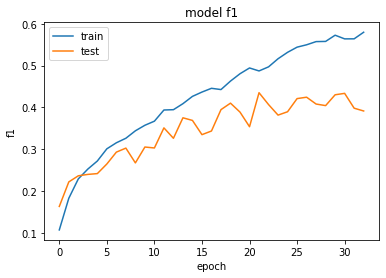

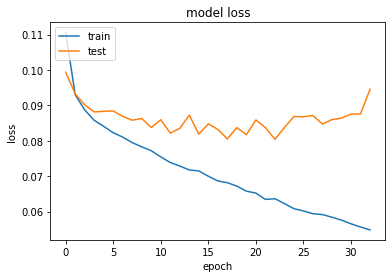

In [28]:
# summarize history for accuracy
plt.plot(history.history['f1'])

plt.plot(history.history['val_f1'])

plt.title('model f1')

plt.ylabel('f1')

plt.xlabel('epoch')

plt.legend(['train','test'], loc='upper left')

plt.show()

# summarize history for loss

plt.plot(history.history['loss'])

plt.plot(history.history['val_loss'])

plt.title('model loss')

plt.ylabel('loss')

plt.xlabel('epoch')

plt.legend(['train','test'], loc='upper left')
plt.show()

In [29]:
output1 = fraud.predict(X_test2_)
output0 = fraud.predict(X_train2_)

In [30]:
roc_auc_score(Y_test2, output1)

0.8391076100874018

In [31]:
roc_auc_score(Y_train2, output0)

0.9406480585193825

In [32]:
output = fraud.predict(X_test_filter_fill.reshape(X_test_filter_fill.shape[0], X_test_filter_fill.shape[1], 1))

In [33]:
output

array([[8.30590725e-05],
       [2.23749876e-03],
       [1.81826949e-03],
       ...,
       [1.07079744e-04],
       [1.39832497e-02],
       [5.28136194e-02]], dtype=float32)

In [34]:
newsample_submission = pd.read_csv('newsample_submission.csv', index_col = 'TransactionID')

In [35]:
newsample_submission['isFraud'] = output
newsample_submission.to_csv('newsample_submission_lenet.csv')

In [36]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

In [37]:
import math
results = []
threshold_options = list(np.arange (0.01, 0.16, 0.01))

for threshold in threshold_options:
    pred = [math.ceil(x) if x > threshold else 0 for x in output1]
    acc_lenet = accuracy_score(Y_test2, pred) # accuracy
    auroc_lenet = roc_auc_score(Y_test2, pred) # auroc

    results.append([threshold, acc_lenet, auroc_lenet])

In [38]:
acc_lenet,auroc_lenet

(0.974502487562189, 0.7189194455269164)

In [39]:
precision_recall_fscore_support(Y_test2, pred, average=None)

(array([0.98384018, 0.56906077]),
 array([0.9900128 , 0.44782609]),
 array([0.98691684, 0.50121655]),
 array([7810,  230]))

<Figure size 3600x2400 with 0 Axes>

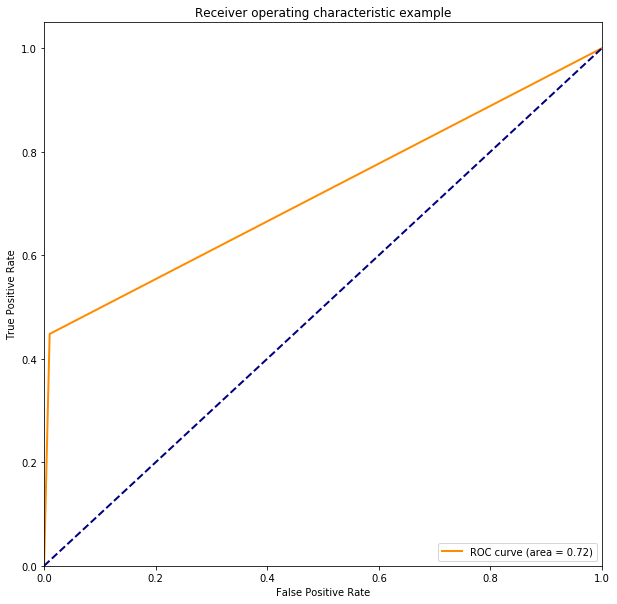

In [40]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(Y_test2, pred) # calculate false positive and true positive
roc_auc = auc(fpr,tpr) # auc


plt.figure(dpi=600)
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) 
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

plt.savefig('lenet_600.png', dpi=600)
plt.savefig('lenet_150.png', dpi=150)

# AlexNet

In [41]:
def alexnet_1D(length):
    inputs = Input((length, 1))
    x = Conv1D(64, 7, strides = 2, padding = 'same')(inputs)
    x = Conv1D(96, 11,strides = 4, padding = 'same')(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D()(x)
    x = Dropout(0.25)(x)
    
    x = Conv1D(256, 5,strides = 4, padding = 'same')(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D()(x)
    x = Dropout(0.25)(x)
    
    x = Conv1D(384, 3,strides = 4, padding = 'same')(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = Conv1D(384, 3,strides = 4, padding = 'same')(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = Conv1D(256, 3,strides = 4, padding = 'same')(x)
    #x = MaxPooling1D()(x)
    x = Dropout(0.25)(x)
    
    x = Flatten()(x)
    x = Dense(4096)(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
    
    x = Dense(4096)(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
    
    x = Dense(1)(x)
    x = Activation('sigmoid')(x)
    
    model = models.Model(inputs = inputs, outputs = x)
    
    return model

In [42]:
fraud_2 = alexnet_1D(X_train2.shape[-1])

In [43]:
from keras import optimizers
sgd = optimizers.SGD(lr=.1, momentum=0.9, nesterov=True)
fraud_2.compile(loss='binary_crossentropy', optimizer=sgd, metrics=[f1])

In [44]:
fraud_2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 225, 1)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 113, 64)           512       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 29, 96)            67680     
_________________________________________________________________
activation_1 (Activation)    (None, 29, 96)            0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 29, 96)            384       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 14, 96)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 96)            0   

In [45]:
Y_train2.values

array([0, 0, 0, ..., 0, 0, 0])

In [46]:
history_2 = fraud_2.fit(X_train2_, Y_train2, batch_size=128, epochs=200, validation_data=(X_test2_, Y_test2)
                   , callbacks=[checkpoint_period, reduce_lr, early_stopping])

Train on 72357 samples, validate on 8040 samples
Epoch 1/200
72357/72357 [==============================] - 194s 3ms/step - loss: 0.2111 - f1: 0.1029 - val_loss: 0.1369 - val_f1: 0.2284
Epoch 2/200
72357/72357 [==============================] - 192s 3ms/step - loss: 0.1181 - f1: 0.1665 - val_loss: 0.1131 - val_f1: 0.1953
Epoch 3/200
72357/72357 [==============================] - 196s 3ms/step - loss: 0.1105 - f1: 0.1943 - val_loss: 0.1002 - val_f1: 0.1692
Epoch 4/200
72357/72357 [==============================] - 195s 3ms/step - loss: 0.1079 - f1: 0.2288 - val_loss: 0.1051 - val_f1: 0.1663
Epoch 5/200
72357/72357 [==============================] - 195s 3ms/step - loss: 0.1020 - f1: 0.2228 - val_loss: 0.1022 - val_f1: 0.2477
Epoch 6/200
72357/72357 [==============================] - 200s 3ms/step - loss: 0.0971 - f1: 0.2431 - val_loss: 0.0952 - val_f1: 0.2026
Epoch 7/200
72357/72357 [==============================] - 205s 3ms/step - loss: 0.0996 - f1: 0.2443 - val_loss: 0.0994 - val_f1:

In [47]:
fraud_2.save(log_dir+'last2_alexnet.h5')

In [48]:
score_2=fraud_2.evaluate(X_test2_, Y_test2,batch_size=128)

8040/8040 [==============================] - 6s 743us/step


In [51]:
print(history_2.history.keys())

dict_keys(['val_loss', 'val_f1', 'loss', 'f1', 'lr'])


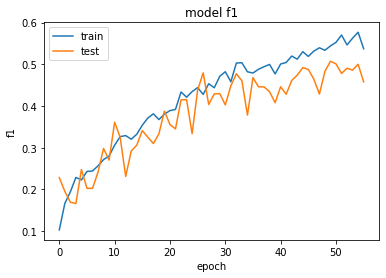

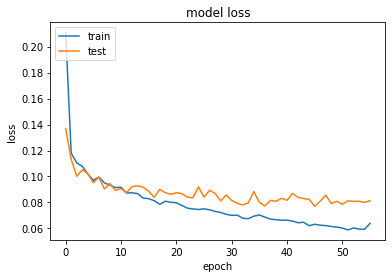

In [52]:
# summarize history for accuracy
plt.plot(history_2.history['f1'])

plt.plot(history_2.history['val_f1'])

plt.title('model f1')

plt.ylabel('f1')

plt.xlabel('epoch')

plt.legend(['train','test'], loc='upper left')

plt.show()

# summarize history for loss

plt.plot(history_2.history['loss'])

plt.plot(history_2.history['val_loss'])

plt.title('model loss')

plt.ylabel('loss')

plt.xlabel('epoch')

plt.legend(['train','test'], loc='upper left')
plt.show()

In [54]:
output1_alex = fraud_2.predict(X_test2_)
output0_alex = fraud_2.predict(X_train2_)

In [55]:
roc_auc_score(Y_test2, output1_alex)

0.8886778377776541

In [56]:
roc_auc_score(Y_train2, output0_alex)

0.9489365548004202

In [57]:
output_alex = fraud_2.predict(X_test_filter_fill.reshape(X_test_filter_fill.shape[0], X_test_filter_fill.shape[1], 1))

In [58]:
output_alex

array([[0.0029954 ],
       [0.00018367],
       [0.00020289],
       ...,
       [0.00258699],
       [0.00379497],
       [0.01357281]], dtype=float32)

In [63]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
import math
results = []
threshold_options = list(np.arange (0.01, 0.16, 0.01))

for threshold in threshold_options:
    pred_alex = [math.ceil(x) if x > threshold else 0 for x in output1_alex]
    acc_alexnet = accuracy_score(Y_test2, pred_alex) # accuracy
    auroc_alexnet = roc_auc_score(Y_test2, pred_alex) # auroc

    results.append([threshold, acc_alexnet, auroc_alexnet])

In [64]:
acc_alexnet,auroc_alexnet

(0.9807213930348259, 0.7326699326393141)

In [65]:
precision_recall_fscore_support(Y_test2, pred_alex, average=None)

(array([0.98455501, 0.76595745]),
 array([0.99577465, 0.46956522]),
 array([0.99013304, 0.58221024]),
 array([7810,  230]))

<Figure size 3600x2400 with 0 Axes>

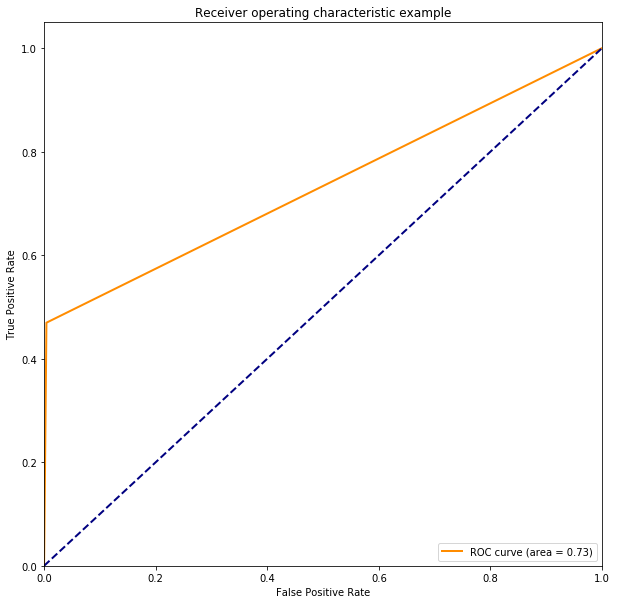

In [69]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr_alex,tpr_alex,threshold_alex = roc_curve(Y_test2, pred_alex) # calculate false positive and true positive
roc_auc_alex = auc(fpr_alex,tpr_alex) # auc


plt.figure(dpi=600)
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr_alex, tpr_alex, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_alex) 
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

<Figure size 3600x2400 with 0 Axes>

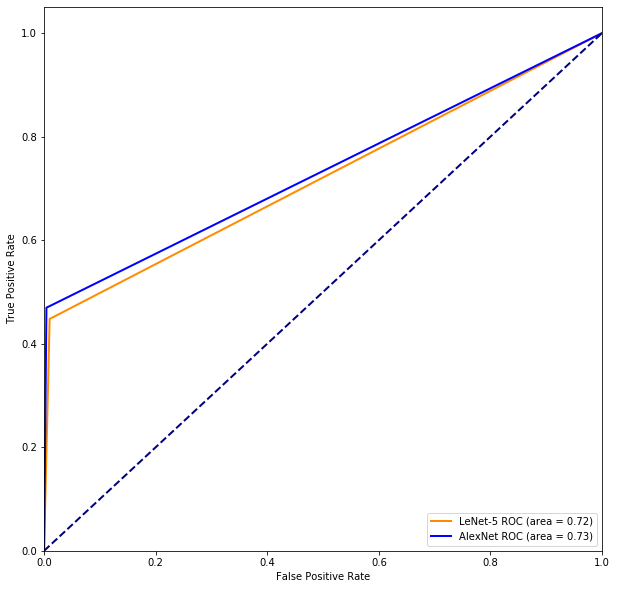

In [71]:
# Compute ROC curve and ROC area for each class

plt.figure(dpi=600)
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='LeNet-5 ROC (area = %0.2f)' % roc_auc) 
plt.plot(fpr_alex, tpr_alex, color='b',
         lw=lw, label='AlexNet ROC (area = %0.2f)' % roc_auc_alex) 

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

#plt.savefig('ROC_600.png', dpi=600)
#plt.savefig('ROC_150.png', dpi=150)

In [86]:
#fpr_res,tpr_res,threshold_res = roc_curve(y_test, y_predict_res) # calculate false positive and true positive
fpr_res = ([0.        , 0.02422535, 1.        ])
tpr_res = ([0.        , 0.78956522, 1.        ])
roc_auc_res = auc(fpr_res,tpr_res) # auc

<Figure size 3600x2400 with 0 Axes>

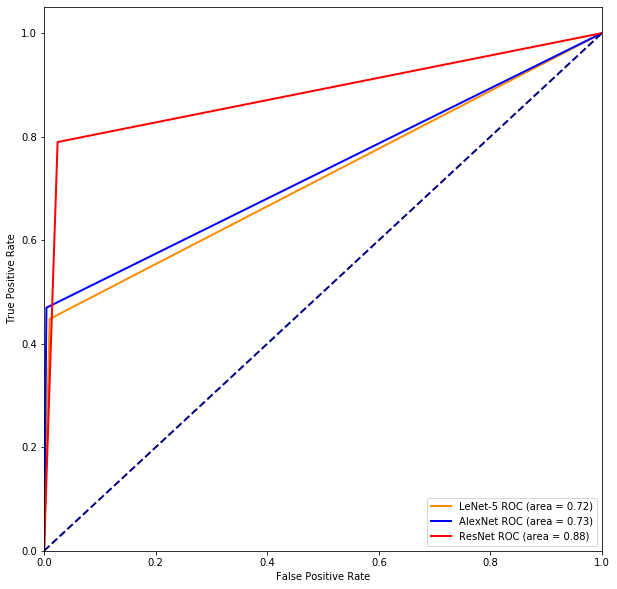

In [88]:
# Compute ROC curve and ROC area for each class

plt.figure(dpi=600)
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='LeNet-5 ROC (area = %0.2f)' % roc_auc) 
plt.plot(fpr_alex, tpr_alex, color='b',
         lw=lw, label='AlexNet ROC (area = %0.2f)' % roc_auc_alex) 
plt.plot(fpr_res, tpr_res, color='r',
         lw=lw, label='ResNet ROC (area = %0.2f)' % roc_auc_res) 

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

plt.savefig('DEEP_ROC_600.png', dpi=600)
plt.savefig('DEEP_ROC_150.png', dpi=150)